In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [46]:
# 1. 데이터 로드
try:
    df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Alcohol_Sales.csv')
    data = df['S4248SM144NCEN'].values.reshape(-1, 1)
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 임시 데이터로 실행합니다.")
    data = np.sin(np.arange(0, 400, 1) * 0.1) * 1000 + 5000 + np.random.rand(400, 1) * 500

In [47]:
# -----------------------------------------------------------------
# 2. Train / Test 데이터 분리 (정규화 *전에* 수행)
# -----------------------------------------------------------------
split_ratio = 0.8
split_point = int(len(data) * split_ratio)

train_data = data[:split_point]
test_data = data[split_point:]

print(f"Total data: {len(data)}")
print(f"Train data: {len(train_data)}")
print(f"Test data: {len(test_data)}")

Total data: 325
Train data: 260
Test data: 65


In [48]:
# -----------------------------------------------------------------
# 3. 정규화 (Scaler를 Train 데이터로만 'fit' 함)
# -----------------------------------------------------------------
scaler = MinMaxScaler()
# 훈련 데이터로만 fit (최소/최대값 학습)
scaler.fit(train_data)

# 훈련/테스트 데이터 변환 (transform)
scaled_train = scaler.transform(train_data)
scaled_test = scaler.transform(test_data)

In [49]:
# -----------------------------------------------------------------
# 4. 시퀀스 생성 (Train/Test 별도 생성)
# -----------------------------------------------------------------
window = 12

def create_sequences(data_scaled, window):
    X, y = [], []
    for i in range(len(data_scaled) - window):
        X.append(data_scaled[i:i+window])
        y.append(data_scaled[i+window])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(scaled_train, window)

# [중요] 테스트 시퀀스를 만들 때, 마지막 훈련 데이터(window-1 만큼)가 필요합니다.
# (예: X_test[0]을 만들려면 train_data의 마지막 부분이 필요함)
# 따라서 scaled_train의 마지막 'window' 만큼을 앞에 붙여줍니다.
temp_test_data = np.concatenate([scaled_train[-window:], scaled_test])
X_test, y_test = create_sequences(temp_test_data, window)

print(f"Train sequences: {len(X_train)}")
print(f"Test sequences: {len(X_test)}")

Train sequences: 248
Test sequences: 65


In [50]:
# 5. SimpleRNN 모델 정의 및 훈련
print("\n--- SimpleRNN 모델 훈련 시작 ---")
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, 1)),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])
model_rnn.compile(optimizer='adam', loss='mse')
model_rnn.fit(X_train, y_train, epochs=50, batch_size=8, verbose=1, # 100 Epochs, verbose=0 (로그 생략)
              validation_data=(X_test, y_test))
print("--- SimpleRNN 모델 훈련 완료 ---")


--- SimpleRNN 모델 훈련 시작 ---
Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0529 - val_loss: 0.0655
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0094 - val_loss: 0.0351
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - val_loss: 0.0514
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0031 - val_loss: 0.0244
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0036 - val_loss: 0.0222
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0352
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0022 - val_loss: 0.0200
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0225
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0144
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0027 - val_loss: 0.0116
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0026 - val_loss: 0.0147
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9m

In [51]:
# 6. LSTM 모델 정의 및 훈련 (추천 구조 및 100 Epochs)
print("\n--- LSTM 모델 훈련 시작 (Stacked) ---")
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(window, 1)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, # 100 Epochs, verbose=0 (로그 생략)
               validation_data=(X_test, y_test))
print("--- LSTM 모델 훈련 완료 ---")


--- LSTM 모델 훈련 시작 (Stacked) ---
Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0940 - val_loss: 0.0707
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0152 - val_loss: 0.0343
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0138 - val_loss: 0.0251
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0114 - val_loss: 0.0248
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0128 - val_loss: 0.0251
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0162 - val_loss: 0.0420
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0126 - val_loss: 0.0247
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0114 - val_loss: 0.0279
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0114 - val_loss: 0.0271
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0116 - val_loss: 0.0302
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - val_loss: 0.0246
Epoch 12/100
31/31 

In [52]:
# 7. 예측 및 평가 (Test 데이터 사용)

# 스케일링된 값(0~1 사이)으로 MSE/RMSE 계산

# RNN 스케일링된 예측 및 평가
mse_rnn_scaled_calc = mean_squared_error(y_test, pred_rnn_scaled) # y_test와 pred_rnn_scaled 사용
rmse_rnn_scaled_calc = np.sqrt(mse_rnn_scaled_calc)
print("\n--- RNN 모델 평가 (Scaled 0~1) ---")
print(f"Scaled MSE: {mse_rnn_scaled_calc:.6f}") # 소수점 6자리까지 표시
print(f"Scaled RMSE: {rmse_rnn_scaled_calc:.6f}")

# LSTM 스케일링된 예측 및 평가
mse_lstm_scaled_calc = mean_squared_error(y_test, pred_lstm_scaled) # y_test와 pred_lstm_scaled 사용
rmse_lstm_scaled_calc = np.sqrt(mse_lstm_scaled_calc)
print("\n--- LSTM 모델 평가 (Scaled 0~1) ---")
print(f"Scaled MSE: {mse_lstm_scaled_calc:.6f}")
print(f"Scaled RMSE: {rmse_lstm_scaled_calc:.6f}")


# 원본 스케일로 복원
y_test_orig = scaler.inverse_transform(y_test)

# RNN 예측 및 평가
pred_rnn_scaled = model_rnn.predict(X_test)
pred_rnn_orig = scaler.inverse_transform(pred_rnn_scaled)
mse_rnn = mean_squared_error(y_test_orig, pred_rnn_orig)
rmse_rnn = np.sqrt(mse_rnn)
print("\n--- RNN 모델 평가 (Test Set) ---")
print(f"MSE: {mse_rnn:.4f}")
print(f"RMSE: {rmse_rnn:.4f}")

# LSTM 예측 및 평가
pred_lstm_scaled = model_lstm.predict(X_test)
pred_lstm_orig = scaler.inverse_transform(pred_lstm_scaled)
mse_lstm = mean_squared_error(y_test_orig, pred_lstm_orig)
rmse_lstm = np.sqrt(mse_lstm)
print("\n--- LSTM 모델 평가 (Test Set) ---")
print(f"MSE: {mse_lstm:.4f}")
print(f"RMSE: {rmse_lstm:.4f}")


--- RNN 모델 평가 (Scaled 0~1) ---
Scaled MSE: 0.013814
Scaled RMSE: 0.117531

--- LSTM 모델 평가 (Scaled 0~1) ---
Scaled MSE: 0.024851
Scaled RMSE: 0.157642
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

--- RNN 모델 평가 (Test Set) ---
MSE: 525476.0216
RMSE: 724.8972
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step

--- LSTM 모델 평가 (Test Set) ---
MSE: 1377475.0704
RMSE: 1173.6588


/tmp/ipython-input-2546770105.py:9: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.savefig('rnn_prediction.png')
/tmp/ipython-input-2546770105.py:9: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.savefig('rnn_prediction.png')
/tmp/ipython-input-2546770105.py:9: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.savefig('rnn_prediction.png')
/tmp/ipython-input-2546770105.py:9: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.savefig('rnn_prediction.png')
/tmp/ipython-input-2546770105.py:9: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.savefig('rnn_prediction.png')



RNN 예측 그래프가 'rnn_prediction.png'로 저장되었습니다.


/tmp/ipython-input-2546770105.py:18: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.savefig('lstm_prediction.png')
/tmp/ipython-input-2546770105.py:18: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.savefig('lstm_prediction.png')
/tmp/ipython-input-2546770105.py:18: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  plt.savefig('lstm_prediction.png')
/tmp/ipython-input-2546770105.py:18: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.savefig('lstm_prediction.png')
/tmp/ipython-input-2546770105.py:18: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  plt.savefig('lstm_prediction.png')


LSTM 예측 그래프가 'lstm_prediction.png'로 저장되었습니다.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


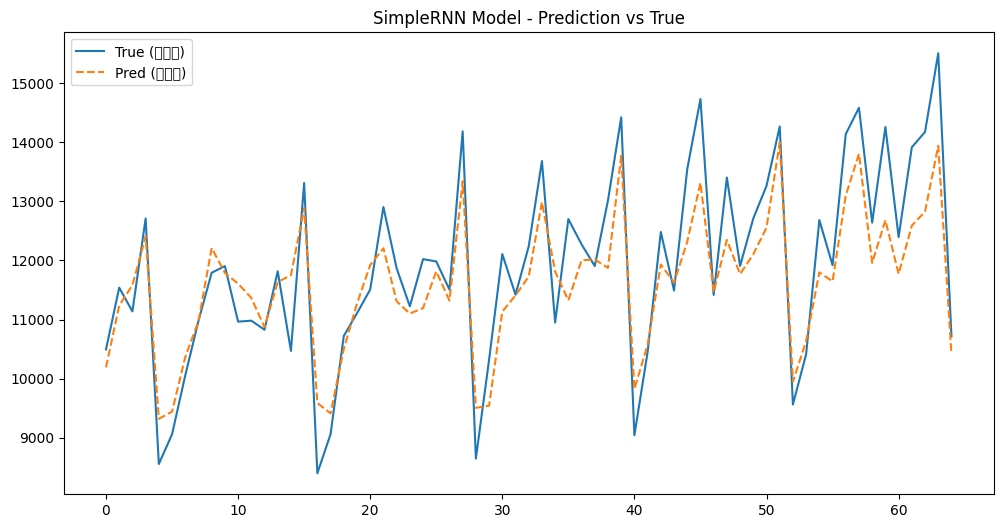

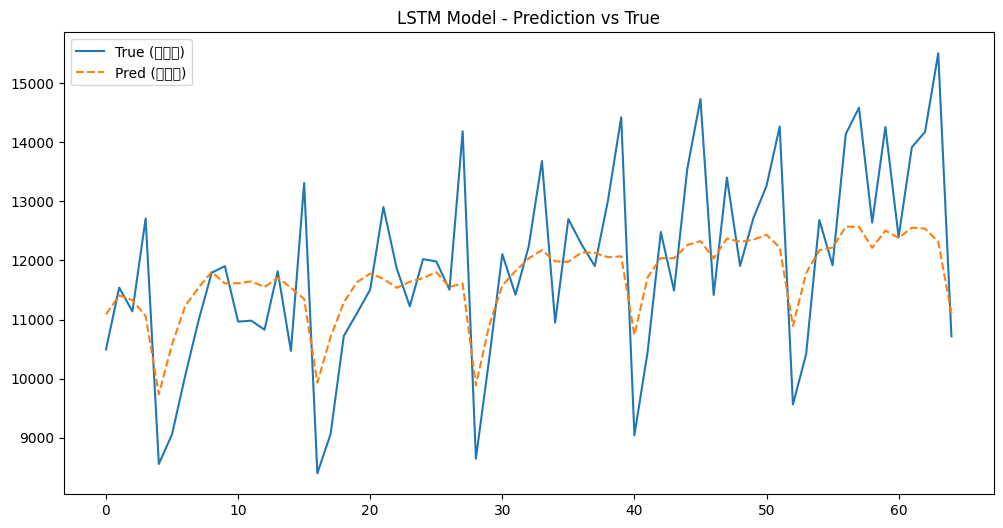

In [53]:
# 8. 그래프 그리기 (2개)

# 그래프 1: RNN 예측
plt.figure(figsize=(12, 6))
plt.title('SimpleRNN Model - Prediction vs True')
plt.plot(y_test_orig, label='True (실제값)')
plt.plot(pred_rnn_orig, label='Pred (예측값)', linestyle='--')
plt.legend()
plt.savefig('rnn_prediction.png')
print("\nRNN 예측 그래프가 'rnn_prediction.png'로 저장되었습니다.")

# 그래프 2: LSTM 예측
plt.figure(figsize=(12, 6))
plt.title('LSTM Model - Prediction vs True')
plt.plot(y_test_orig, label='True (실제값)')
plt.plot(pred_lstm_orig, label='Pred (예측값)', linestyle='--')
plt.legend()
plt.savefig('lstm_prediction.png')
print("LSTM 예측 그래프가 'lstm_prediction.png'로 저장되었습니다.")